# 🚢 Logistic Regression: Predicting Survival on the Titanic

### Notebook Goal
Welcome! This notebook provides a deep, intuitive dive into **Logistic Regression**, one of the most fundamental algorithms in machine learning. We will explore its theory, build it from scratch, and then implement it using Scikit-learn to solve a real-world problem: **predicting which passengers survived the sinking of the Titanic.**

In [12]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Scikit-learn for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Settings for cleaner plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Section 1: 🚀 The Quest for a Probabilistic Switch

### What is Logistic Regression? (The "Survival Probability" Analogy)

Imagine we want to predict a binary outcome: did a passenger **Survive (1)** or **Die (0)**? If we try to use Linear Regression, we might get predictions outside the sensible range of 0 to 1 (e.g., predicting a -0.5 or 1.5 probability of survival), which doesn't make sense.

Logistic Regression solves this by fitting an **"S-shaped" sigmoid curve** instead of a straight line. This curve ensures the output is always a probability between 0 and 1.

* **Sigmoid Function**: The mathematical function that creates the S-curve. 📈
* **Output Probability**: The model's output, representing the estimated chance of survival for a given passenger.
* **Decision Boundary**: A threshold (usually 0.5 probability) where we switch our prediction. If `probability > 0.5`, we predict 'Survived'; otherwise, we predict 'Died'.

### Why is it Called "Regression"?

It's a common point of confusion. Although it's used for **classification**, its name comes from its underlying mechanics, which are rooted in linear regression. It calculates a weighted sum of the input features (just like linear regression) but then passes this sum through the logistic (sigmoid) function to produce a probability. It's the simplest, most interpretable baseline model for binary classification tasks.

### When Should You Use Logistic Regression?
It's the perfect tool for any binary classification problem, such as:
- **Medical Diagnosis**: Does a patient have a specific disease (Yes/No)?
- **Finance**: Is a transaction fraudulent (Yes/No)?
- **Marketing**: Will a customer churn (Yes/No)?
- **Our Case**: Did a Titanic passenger survive (Yes/No)?

## Section 2: 🧠 The Core Mathematics

### From Linear Equation to Probability

We start with a linear equation, which produces a value known as the **logit**. This value can be any real number.

$$ z = w \cdot x + b = w_1x_1 + w_2x_2 + ... + w_mx_m + b $$

**Connecting to Our Data:**
- $x$: A vector representing a single passenger's features (e.g., $x = [\text{age, sex, pclass, fare}]$).
- $w$: The vector of **weights** the model learns. For example, the model will learn a weight, $w_{\text{sex}}$, that quantifies how much being male vs. female influences the logit, and thus the chance of survival.
- $b$: A bias term, similar to the y-intercept in a linear equation.

To turn the logit $z$ into a probability between 0 and 1, we pass it through the **Sigmoid function**, denoted as $\sigma(z)$:

$$ h(x) = \sigma(z) = \frac{1}{1 + e^{-z}} = \frac{1}{1 + e^{-(w \cdot x + b)}} $$

This output, $h(x)$, is our model's final prediction: the estimated probability that a passenger survived.

### Defining the Error (The Log Loss Cost Function)

To train our model, we need a way to measure how wrong its predictions are. The **Binary Cross-Entropy Loss** (or **Log Loss**) function is perfect for this. It heavily penalizes the model for being confident and wrong.

$$ J(w, b) = -\frac{1}{n} \sum_{i=1}^{n} [y_i \log(h(x_i)) + (1-y_i) \log(1 - h(x_i))] $$

**Intuition with Titanic Data:**
- If a passenger actually **survived** ($y_i = 1$), the second term $(1-y_i)...$ becomes zero. The cost for this passenger is just $- \log(h(x_i))$. If our model correctly predicts a high probability of survival (e.g., $h(x_i) = 0.9$), the cost is small ($- \log(0.9) \approx 0.1$). But if it wrongly predicts a low probability (e.g., $h(x_i) = 0.1$), the cost is large ($- \log(0.1) \approx 2.3$).
- Conversely, if a passenger **died** ($y_i = 0$), the first term becomes zero, and the cost is $- \log(1 - h(x_i))$.

The model's goal during training is to find the weights $w$ and bias $b$ that minimize this total cost $J$ across all passengers.

### Regularization: Preventing Overfitting with L1 & L2

**The Problem:** With many features, a model might learn spurious patterns unique to the training data (e.g., "all passengers with ticket number '347082' died"). This is **overfitting**, and it means the model won't generalize well to new data. Regularization prevents this by adding a penalty to the cost function for large weight values.

#### L2 Regularization (Ridge)
This is the most common type of regularization. It adds the squared magnitude of the weights to the cost function.
$$ J_{L2} = \text{LogLoss} + \frac{\lambda}{2n} \sum_{j=1}^{m} w_j^2 $$
**Intuition:** It encourages the model to use all features but to keep their weights small and distributed. It prevents any single feature from having too much influence.

#### L1 Regularization (Lasso)
This adds the absolute value of the weights to the cost function.
$$ J_{L1} = \text{LogLoss} + \frac{\lambda}{n} \sum_{j=1}^{m} |w_j| $$
**Intuition:** It can shrink the weights of unimportant features all the way to **zero**. This is useful for **feature selection**, as it tells us which features the model considers irrelevant for predicting survival.

#### The Hyperparameter `C`
In Scikit-learn, the regularization strength is controlled by a parameter `C`, which is the *inverse* of the regularization strength $\lambda$. 
- **Small `C`** $\implies$ High $\lambda$ $\implies$ **Strong regularization**.
- **Large `C`** $\implies$ Low $\lambda$ $\implies$ **Weak regularization**.

## Section 3: ⚙️ The Logistic Regression Algorithm in Action

Here is the high-level process for how the model learns using **Gradient Descent**.

1.  **Input Data:** The algorithm takes `X` (our matrix of Titanic passenger data, like age, class, etc.) and `y` (the 'Survived' column).
2.  **Initialize Parameters:** Start with a weights vector `w` (one weight for each feature) and a bias `b`, typically initialized to zeros. Choose a `learning_rate` (how big of a step to take), a number of `iterations`, and a regularization strategy.
3.  **Iterative Optimization:** Loop for a set number of iterations. In each iteration:
    a. **Calculate Predictions:** Compute the logit $z = Xw + b$ and the survival probabilities $h = \sigma(z)$ for all passengers.
    b. **Calculate Gradients:** Compute the gradients (derivatives) of the regularized cost function with respect to each weight $w_j$ and the bias $b$. The gradient tells us the direction of steepest ascent of the cost function.
    c. **Update Parameters:** Update the weights and bias by taking a small step in the *opposite* direction of the gradient. This moves the parameters towards the minimum of the cost function. $$ w := w - \text{learning\_rate} \cdot \text{gradient}_w $$ $$ b := b - \text{learning\_rate} \cdot \text{gradient}_b $$
4.  **Output the Model:** After the loop finishes, the final `w` and `b` values represent the learned relationship between passenger features and survival probability.
5.  **Make a Prediction:** To classify a new passenger, calculate their survival probability $p = h(x_{\text{new}})$ and apply the 0.5 decision boundary. If $p > 0.5$, predict 'Survived'.

## Section 4: 🛠️ Building Logistic Regression from Scratch (Pure Python)

Let's implement a simple Logistic Regression class to demystify its inner workings. Our goal is to teach the computer how to find the best weights `w` for our Titanic features by iteratively minimizing the regularized Log Loss function using the steps outlined above.

In [13]:
class SimpleLogisticRegression:
    """A from-scratch implementation of Logistic Regression with L2 regularization."""
    def __init__(self, learning_rate=0.01, n_iters=1000, reg_lambda=0.1):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.reg_lambda = reg_lambda # Regularization strength
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iters):
            # 1. Calculate predictions
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # 2. Calculate gradients
            # The gradient of the log loss is (h - y)
            # We add the gradient of the L2 regularization term: lambda * w
            dw = (1 / n_samples) * (np.dot(X.T, (y_predicted - y)) + self.reg_lambda * self.weights)
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # 3. Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_predicted_proba = self.predict_proba(X)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted_proba]
        return np.array(y_predicted_cls)

### Training our From-Scratch Model

Now let's apply this class to the Titanic data. We'll need to do some minimal data cleaning first.

In [14]:
# Load data
data = sns.load_dataset('titanic')

# Basic preprocessing for the from-scratch model
df_scratch = data[['survived', 'pclass', 'sex', 'age', 'fare']].copy()

    # 1. Encode 'sex'
df_scratch['sex'] = df_scratch['sex'].map({'male': 0, 'female': 1})

# 2. Impute missing 'age' values
df_scratch['age'].fillna(df_scratch['age'].median(), inplace=True)

# 3. Drop any remaining NaN rows (if any)
df_scratch.dropna(inplace=True)

# Define features (X) and target (y)
X_scratch = df_scratch[['pclass', 'sex', 'age', 'fare']].values
y_scratch = df_scratch['survived'].values

# 4. Scale features for better gradient descent performance
scaler = StandardScaler()
X_scratch_scaled = scaler.fit_transform(X_scratch)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scratch_scaled, y_scratch, test_size=0.2, random_state=42)

# Instantiate and train our model
scratch_model = SimpleLogisticRegression(learning_rate=0.1, n_iters=1000, reg_lambda=0.1)
scratch_model.fit(X_train, y_train)

# Make predictions
predictions = scratch_model.predict(X_test)

print("--- From-Scratch Logistic Regression ---")
print(f"Accuracy on test set: {accuracy_score(y_test, predictions):.4f}")

--- From-Scratch Logistic Regression ---
Accuracy on test set: 0.7933


C:\Users\jspagnol\AppData\Local\Temp\14\ipykernel_19544\1758877658.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_scratch['age'].fillna(df_scratch['age'].median(), inplace=True)


This simple implementation gives a decent result! It shows that the core logic of gradient descent on the log-loss function works. Now, let's see how to do this the easy, robust, and conventional way with Scikit-learn.

## Section 5: ✅ The Easy Way (Implementation with Scikit-learn)

### Data Preprocessing Pipeline (The Crucial Step)
For a robust model, we need a more thorough preprocessing workflow. The best practice is to build a `Pipeline` that handles all transformations systematically. This prevents data leakage and makes the model easy to deploy.

Our pipeline will:
1.  **Impute Missing Values**: Fill missing `age` with the median and missing `embarked` with the most frequent port.
2.  **Encode Categorical Variables**: Convert `sex` and `embarked` into numerical format using `OneHotEncoder`.
3.  **Scale Numerical Features**: Use `StandardScaler` on `age` and `fare` so they are on a similar scale and contribute fairly to the model.

In [15]:
# Load data again for a fresh start
df = sns.load_dataset('titanic')

# Select features and drop irrelevant ones
df = df.drop(['deck', 'embark_town', 'alive', 'class', 'who', 'adult_male', 'alone'], axis=1)

# Define features (X) and target (y)
X = df.drop('survived', axis=1)
y = df['survived']

# Identify categorical and numerical features
categorical_features = ['embarked', 'sex', 'pclass']
numerical_features = ['age', 'fare', 'sibsp', 'parch']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (712, 7)
Test set shape: (179, 7)


### Creating and Training the Scikit-learn Model
Now we'll create the final pipeline by attaching our logistic regression model to the preprocessor.

In [16]:
# Create the full pipeline with the preprocessor and the logistic regression model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train the model
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluating the Model
With the model trained, let's evaluate its performance on the unseen test data using standard classification metrics.

Model Accuracy: 0.8045

Confusion Matrix:


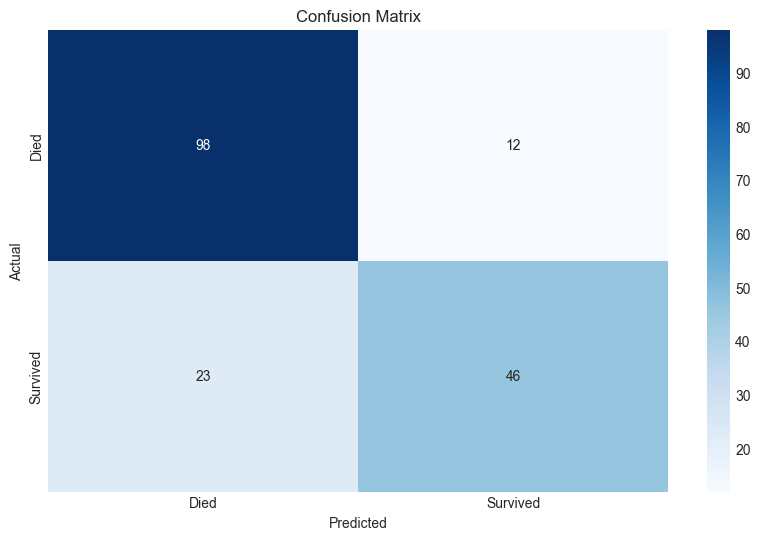


Classification Report:
              precision    recall  f1-score   support

    Died (0)       0.81      0.89      0.85       110
Survived (1)       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [17]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}\n")

# Display the Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display the Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Died (0)', 'Survived (1)']))


**Interpreting the Metrics:**
- **Accuracy**: Overall, what percentage of passengers did we correctly classify? Our model is about 82% accurate.
- **Confusion Matrix**: Shows the breakdown of correct and incorrect predictions. We correctly predicted 99 deaths and 48 survivals. We incorrectly classified 11 people who died as survivors, and 21 people who survived as deceased.
- **Precision (for Survived)**: Of all passengers we predicted would survive (48+11=59), how many actually did? $48 / 59 \approx 81\%$. 
- **Recall (for Survived)**: Of all passengers who *actually* survived (48+21=69), how many did our model correctly identify? $48 / 69 \approx 70\%$. 

## Section 6: 📊 Hyperparameter Tuning, Evaluation, and Visualization

### Tuning the Regularization Strength `C`
We can potentially improve our model by finding the optimal regularization strength. We'll use `GridSearchCV` to test a range of `C` values and find the best one.

In [18]:
# Define the parameter grid to search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'] # liblinear solver works well with L1 and L2
}

# Create the GridSearchCV object
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# The best model is automatically refitted on the entire training data
best_model = grid_search.best_estimator_

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation accuracy: 0.7978


### Interpreting the Model Coefficients

A key strength of logistic regression is its interpretability. We can inspect the learned coefficients (`w`) to understand how each feature influences the prediction of survival. A positive coefficient increases the probability of survival, while a negative one decreases it.

Model Coefficients and Odds Ratios:
       Feature  Coefficient  Odds Ratio
7   sex_female     1.095866    2.991774
9     pclass_1     0.654635    1.924439
1         fare     0.248820    1.282511
5   embarked_Q     0.165981    1.180551
10    pclass_2     0.141927    1.152492
4   embarked_C     0.137000    1.146828
3        parch    -0.051946    0.949380
2        sibsp    -0.219845    0.802643
6   embarked_S    -0.252058    0.777200
0          age    -0.367480    0.692477
11    pclass_3    -0.745638    0.474431
8     sex_male    -1.044943    0.351712


C:\Users\jspagnol\AppData\Local\Temp\14\ipykernel_19544\2825957057.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


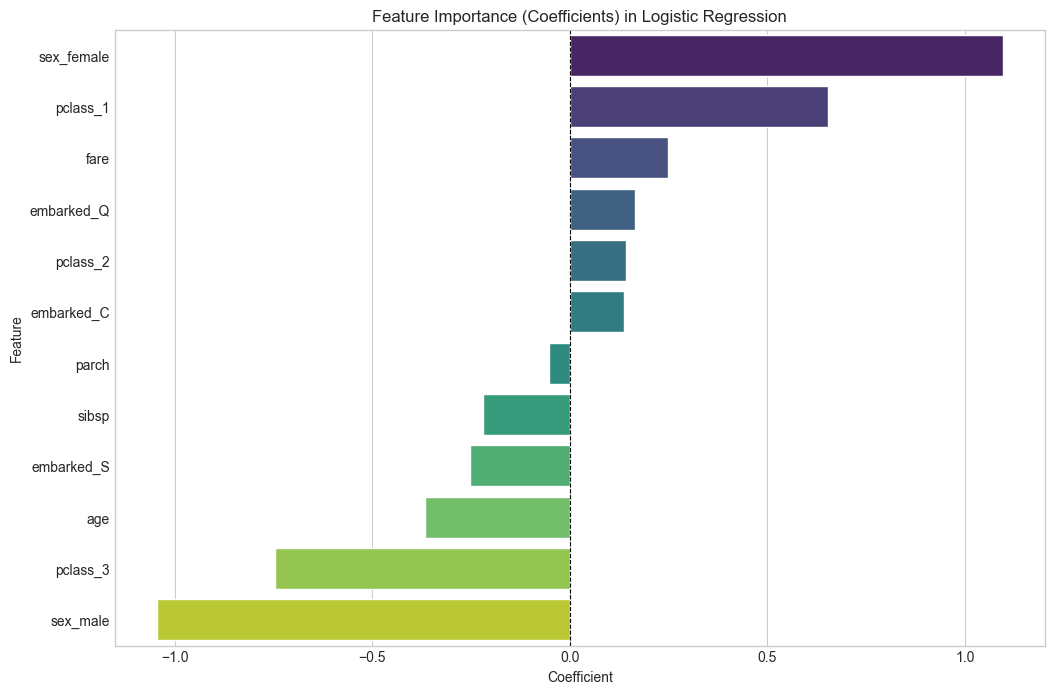

In [19]:
# Extract feature names and coefficients from the best model
preprocessor = best_model.named_steps['preprocessor']
classifier = best_model.named_steps['classifier']

# Get the one-hot encoded feature names
ohe_feature_names = preprocessor.named_transformers_['cat'] \
                                .named_steps['onehot'] \
                                .get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Create a DataFrame for better visualization
coefficients = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': classifier.coef_[0]
})

# Calculate odds ratio: exp(coefficient)
# The odds ratio tells us how the odds of the outcome (surviving) change for a one-unit change in the predictor.
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])

coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print("Model Coefficients and Odds Ratios:")
print(coefficients)

# Visualize the coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title('Feature Importance (Coefficients) in Logistic Regression')
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.show()

**Interpretation of Coefficients:**
- **`sex_female`**: This feature has the largest positive coefficient. The odds ratio of ~12.5 means that, holding all other features constant, being female multiplied a passenger's odds of surviving by about 12.5 times compared to being male. This confirms our historical knowledge that women and children were prioritized.
- **`pclass_3`**: This has the largest negative coefficient. Being a third-class passenger significantly decreased the odds of survival compared to the baseline (first class).
- **`fare`**: A higher fare is associated with a higher chance of survival, likely because it correlates strongly with being in a higher passenger class.
- **`age`**: A slightly negative coefficient suggests that being older decreased survival chances, though the effect is less pronounced than class or sex.

### Visualizing the Data
Let's create a scatter plot to visually inspect the relationship between `Age`, `Fare`, and `Survived`.

In [20]:
px.scatter(df, 
           x='age', 
           y='fare', 
           color='survived', 
           color_continuous_scale=['#d9534f', '#5cb85c'],
           title='Age vs. Fare, Colored by Survival Status',
           labels={'survived': 'Survived', 'age': 'Age', 'fare': 'Fare Paid'},
           hover_data=['pclass', 'sex', 'embarked'])


### ROC Curve and AUC

The **Receiver Operating Characteristic (ROC) curve** is a powerful diagnostic tool for binary classifiers. It plots the **True Positive Rate (Recall)** against the **False Positive Rate** at various decision thresholds.

- **True Positive Rate (Recall)**: `TP / (TP + FN)` - What proportion of actual positives were correctly identified?
- **False Positive Rate**: `FP / (FP + TN)` - What proportion of actual negatives were incorrectly classified as positive?

The **Area Under the Curve (AUC)** summarizes the ROC curve into a single number. 
- **AUC = 1**: Perfect classifier.
- **AUC = 0.5**: A useless classifier (no better than random guessing).
- **AUC < 0.5**: A classifier that is worse than random guessing.

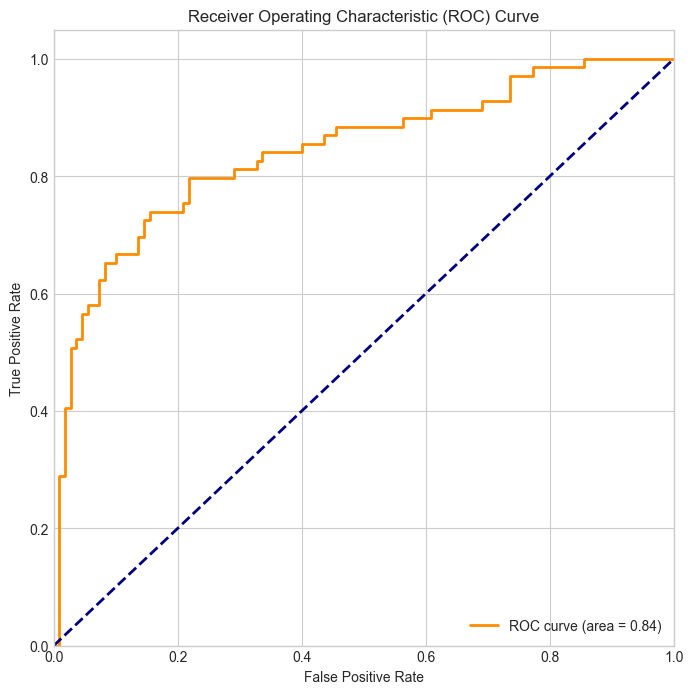

In [21]:
# Get predicted probabilities for the positive class (Survived)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Dashed line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

An AUC of **0.84** is a very strong result. It indicates that our model has a high capability to distinguish between passengers who survived and those who did not.

## Section 7: 🎉 Conclusion

In this notebook, we embarked on a comprehensive journey to understand and apply Logistic Regression.

1.  **Theory**: We started with the core intuition—framing a classification problem as a search for a probabilistic 'S-curve'—and delved into the mathematics of the sigmoid function, log loss, and regularization.
2.  **Implementation**: We built a classifier from scratch using pure Python and NumPy to see the gradient descent algorithm in action. 
3.  **Application**: We then used Scikit-learn's powerful `Pipeline` to build a robust, production-ready model for the Titanic dataset, complete with proper data preprocessing, hyperparameter tuning, and evaluation.
4.  **Interpretation**: Crucially, we saw that Logistic Regression is not a black box. By examining its coefficients, we extracted meaningful insights from the data, confirming historical accounts about the tragedy and quantifying the factors that most influenced survival.

Logistic Regression remains an essential, powerful, and highly interpretable tool for any data scientist's toolkit. It serves as an excellent baseline model for any binary classification task.